## Pre-trained AlexNet Model Adapted to Custom Photos

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# # ignore harmless warnings
# import warnings
# warnings.filterwarnings("ignore")

### Define transforms
Here lists a recommended combination of transforms for data augmentation (rotate, flip, etc.) and normalization.

In [2]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

### Prepare train and data test sets, loaders
We're going to take advantage of a built-in torchvision dataset tool called <a href='https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder'><tt><strong>ImageFolder</strong></tt></a>.

In [3]:
pwd

'C:\\Users\\z1061\\Projects\\Tutorials\\PyTorch\\CNN'

In [4]:
root = './CATS_DOGS'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['CAT', 'DOG']
Training images available: 1350
Testing images available:  586


### Display a batch of images
To verify that the training loader selects cat and dog images at random, let's show a batch of loaded images.<br>
Recall that imshow clips pixel values <0, so the resulting display lacks contrast. We'll apply a quick inverse transform to the input tensor so that images show their "true" colors.

In [5]:
# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

print(images[0], '\n', labels[0])

tensor([[[ 1.3070,  1.2385,  1.2557,  ..., -2.1179, -2.1179, -2.1179],
         [ 1.2899,  1.2385,  1.2557,  ..., -2.1179, -2.1179, -2.1179],
         [ 1.2899,  1.2385,  1.2385,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ...,  1.1700,  1.0502,  1.0331],
         [-2.1179, -2.1179, -2.1179,  ...,  1.2214,  1.1872,  1.1015],
         [-2.1179, -2.1179, -2.1179,  ...,  1.2043,  1.1872,  1.0844]],

        [[ 1.4832,  1.4132,  1.4307,  ..., -2.0357, -2.0357, -2.0357],
         [ 1.4657,  1.4132,  1.4307,  ..., -2.0357, -2.0357, -2.0357],
         [ 1.4657,  1.4132,  1.4132,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ...,  0.9405,  0.8179,  0.8004],
         [-2.0357, -2.0357, -2.0357,  ...,  0.9930,  0.9580,  0.8704],
         [-2.0357, -2.0357, -2.0357,  ...,  0.9755,  0.9580,  0.8529]],

        [[ 1.5942,  1.5245,  1.5420,  ..., -1.8044, -1.8044, -1.8044],
         [ 1.5768,  1.5245,  1.5420,  ..., -1

Label: [1 1 1 0 0 0 1 1 0 1]
Class: DOG DOG DOG CAT CAT CAT DOG DOG CAT DOG
image size: [10, 3, 224, 224]


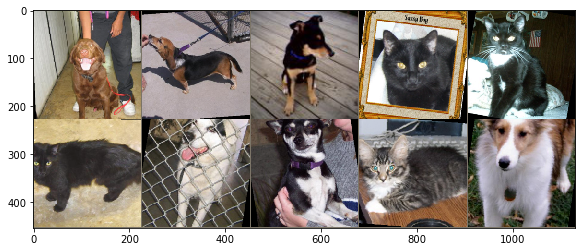

In [6]:
# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

print('image size:', list(images.shape))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

### Download a pretrained model
Torchvision has a number of proven models available through <a href='https://pytorch.org/docs/stable/torchvision/models.html#classification'><tt><strong>torchvision.models</strong></tt></a>:
<ul>
<li><a href="https://arxiv.org/abs/1404.5997">AlexNet</a></li>
<li><a href="https://arxiv.org/abs/1409.1556">VGG</a></li>
<li><a href="https://arxiv.org/abs/1512.03385">ResNet</a></li>
<li><a href="https://arxiv.org/abs/1602.07360">SqueezeNet</a></li>
<li><a href="https://arxiv.org/abs/1608.06993">DenseNet</a></li>
<li><a href="https://arxiv.org/abs/1512.00567">Inception</a></li>
<li><a href="https://arxiv.org/abs/1409.4842">GoogLeNet</a></li>
<li><a href="https://arxiv.org/abs/1807.11164">ShuffleNet</a></li>
<li><a href="https://arxiv.org/abs/1801.04381">MobileNet</a></li>
<li><a href="https://arxiv.org/abs/1611.05431">ResNeXt</a></li>
</ul>
These have all been trained on the <a href='http://www.image-net.org/'>ImageNet</a> database of images. Our only task is to reduce the output of the fully connected layers from (typically) 1000 categories to just 2.

To access the models, you can construct a model with random weights by calling its constructor:<br>
<pre>resnet18 = models.resnet18()</pre>
You can also obtain a pre-trained model by passing pretrained=True:<br>
<pre>resnet18 = models.resnet18(pretrained=True)</pre>
All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

Feel free to investigate the different models available. Each one will be downloaded to a cache directory the first time they're accessed - from then on they'll be available locally.

For its simplicity and effectiveness, we'll use AlexNet:

In [8]:
AlexNetmodel = models.alexnet(pretrained=True)
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

<img src="https://neurohive.io/wp-content/uploads/2018/10/AlexNet-1.png" height="300px" width="500px" >

<div class="alert alert-info">This model uses <a href='https://pytorch.org/docs/master/nn.html#torch.nn.AdaptiveAvgPool2d'><tt><strong>torch.nn.AdaptiveAvgPool2d(<em>output_size</em>)</strong></tt></a> to convert the large matrix coming out of the convolutional layers to a (6x6)x256 matrix being fed into the fully connected layers.</div>

### Freeze feature parameters
We want to freeze the pre-trained weights & biases. We set <tt>.requires_grad</tt> to False so we don't backprop through them.

In [11]:
for param in AlexNetmodel.parameters():
    param.requires_grad = False

### Modify the classifier
Next we need to modify the fully connected layers to produce a binary output. The section is labeled "classifier" in the AlexNet model.<br>
Note that when we assign new layers, their parameters default to <tt>.requires_grad=True</tt>.

In [12]:
torch.manual_seed(42)
AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(1024, 2),
                                 nn.LogSoftmax(dim=1))
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4)
    (3): Linear(in_featur

In [14]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

count_parameters(AlexNetmodel)

 9437184
    1024
    2048
       2
________
 9440258


### Define loss function & optimizer
We only want to optimize the classifier parameters, as the feature parameters are frozen.

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr=0.001)

### Train the model
Remember, we're only training the fully connected layers. The convolutional layers have fixed weights and biases. For this reason, we only need to run one epoch.

In [27]:
import time
start_time = time.time()

epochs = 1

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = AlexNetmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%20 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/x000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = AlexNetmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:   20 [   200/x000]  loss: 0.14743060  accuracy:  96.500%
epoch:  0  batch:   40 [   400/x000]  loss: 0.00764811  accuracy:  96.750%
epoch:  0  batch:   60 [   600/x000]  loss: 0.32074577  accuracy:  97.167%
epoch:  0  batch:   80 [   800/x000]  loss: 0.00179709  accuracy:  97.375%
epoch:  0  batch:  100 [  1000/x000]  loss: 0.00001163  accuracy:  97.700%
epoch:  0  batch:  120 [  1200/x000]  loss: 0.08219653  accuracy:  97.667%

Duration: 44 seconds


In [39]:
total_test = len(test_loader)*10
print(test_correct[0].item())
print(f'Test accuracy: {test_correct[-1].item()*100/total_test:.3f}%')

556
Test accuracy: 94.237%


In [51]:
# Check the number of images in the last test batch
count = 0
for a,b in test_loader:
    count += 1
    if count == 59:
        print(len(a),len(b))

6 6


## Run a new image through the model
We can also pass a single image through the model to obtain a prediction.<br>
Pick a number from 0 to 400, assign it to "x", and we'll use that value to select an image from the Cats and Dogs test set.

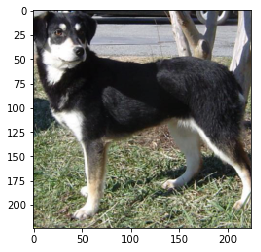

In [52]:
x = 500
im = inv_normalize(test_data[x][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [53]:
test_data[x][0].shape

torch.Size([3, 224, 224])

In [54]:
# AlexNet Model Prediction:

AlexNetmodel.eval()
with torch.no_grad():
    new_pred = AlexNetmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 1 DOG
